# Average the gene expression per cluster 
Calculate the average gene expression per cluster. A pseudobulk approach for single cell datasets where the gene expression is averaged per group of cells; usually these groups are the identified clusters. Eventually a heatmap is drawn with the calculated values

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print(f"scanpy version: {sc.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

scanpy version: 1.10.2
pandas version: 2.2.2
numpy version: 1.26.4


### Order of averaging and log transforming
When calculatubg the per group average of gene expression one has to choices:
1. First calculate the average of the expression of a gene per group, then log transform: 
$$
\displaystyle\log{\left(\frac{\displaystyle\sum_{n=1}^m X_n}{m}\right)}
$$
2. First log transform the expression of a gene per group, then calculate the average:
$$
\frac{\displaystyle\sum_{n=1}^m \log{\left(X_n\right)}}{m}
$$

where $m$ is the number of cells in a group and $X_n$ the counts of cell $n$ for a particular gene 

The two alternatives are not mathematically equivalent. 

Option 1 is the correct approach. By first averaging the counts, we get an "average cell" per group. Afterwards, these values are log transformed to reduce extremeties between high al low counts

### Demonstrate that the two approaces result in different output

In [40]:
# A counts list with 3 values
counts = pd.Series([1, 4, 20])

# First average, then log transform
print(f"First average, then log transform: {np.log(counts.mean())}")

# First log transform, then average
print(f"First log transform, then average: {np.log(counts).mean()}")

First average, then log transform: 2.120263536200091
First log transform, then average: 1.4606755448912938


## A function to Calculate the per group average gene expression
* Normalize raw counts
* Calculate mean expression per gene
* log transform means

In [5]:
def per_group_cluster(adata, group_id = "leiden", target_sum = 1e6, dataset_id = "dataset"):
    """
    Calculates the mean of each gene across all cells in a group
        Parameters:
            adata (AnnData): AnnData object 
            group_id (str): name of key in adata.obs to group the cells by. Defauls to leiden clustering
            target_sum (int): target sum, to be passed to `sc.pp.normalize_total`. Defaults to 1e6,
            which results in a Counts Per Million (CPM) normalization
            dataset_id (str): An identifier for the dataset. Defaults to "dataset"
        Returns:
            mean_log_per_group (pandas.DataFrame): dataframe of mean log transformed values for each gene for each group
    """

    # Raw counts can be stored in counts layer or in .raw.X
    try:
        adata.X = adata.layers["counts"].copy()
    except KeyError:
        adata.X = adata.raw.X.copy()
    sc.pp.normalize_total(adata, target_sum=target_sum)
    # sc.pp.log1p(adata)
    
    dfs = []
    for id in adata.obs[group_id].unique():
        adata_subset = adata.X[adata.obs[group_id] == id,:]
        row_sum = adata_subset.sum(axis=0)
        n_cells = adata_subset.shape[0]
        row_mean = row_sum/n_cells
        row_mean_log = np.log(row_mean+1)
        print(f"Group_{id} has {n_cells} cells. The mean of normalized, log tranformed counts across all genes is {row_mean_log.mean()}.")
        mean_log_df = pd.DataFrame(row_mean_log, columns=adata.var_names, index=[f"{dataset_id}_{id}"])
        dfs.append(mean_log_df)
    
    mean_log_per_group = pd.concat(dfs)
    return mean_log_per_group

# Read Anndata objects

### Latests iPSC dataset

In [6]:
adata_iPSC = sc.read_h5ad("/path/to/arend_pgclcs_scanpy_no_D30_subsampled_30000.h5ad")
adata_iPSC

AnnData object with n_obs × n_vars = 30000 × 17372
    obs: 'run', 'cell_line', 'day', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'pct_dis', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'run_colors', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities'

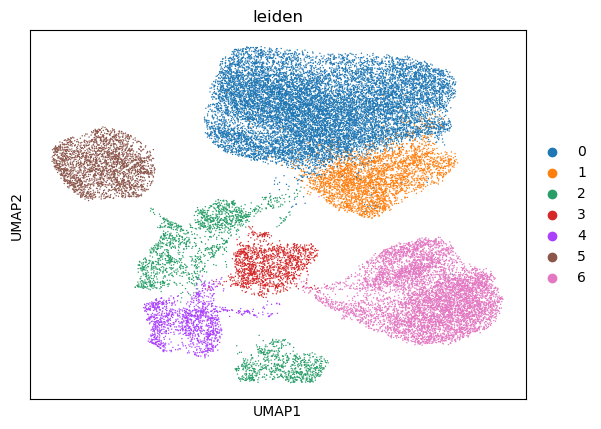

In [7]:
sc.pl.umap(adata_iPSC,
           color=["leiden"],
           )

### Confirm presence of raw counts
They are expected in either `adata.layers["counts"]` or in `adata.raw.X`

In [8]:
adata_iPSC.layers["counts"][0:10, 0:10].toarray()

array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [2., 1., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 0., 3., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 2., 0., 0.]], dtype=float32)

In [23]:
mean_log_iPSC = per_group_cluster(adata=adata_iPSC, 
                                  group_id="leiden", 
                                  target_sum=1e6, 
                                  dataset_id="iPSC")

Group_6 has 6326 cells. The mean of normalized, log tranformed counts across all genes is 2.6558516025543213.
Group_0 has 13122 cells. The mean of normalized, log tranformed counts across all genes is 2.7042903900146484.
Group_2 has 2279 cells. The mean of normalized, log tranformed counts across all genes is 2.7938942909240723.
Group_1 has 3105 cells. The mean of normalized, log tranformed counts across all genes is 2.6565213203430176.
Group_4 has 1363 cells. The mean of normalized, log tranformed counts across all genes is 2.6497714519500732.
Group_3 has 1406 cells. The mean of normalized, log tranformed counts across all genes is 2.682682991027832.
Group_5 has 2399 cells. The mean of normalized, log tranformed counts across all genes is 2.7055044174194336.


### Tyser
Load object previiusly created with R

In [24]:
adata_tyser = sc.read_h5ad("/path/to/tyser_hiPSC_seurat/tyser.h5ad")
adata_tyser

AnnData object with n_obs × n_vars = 1069 × 57490
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features'

In [11]:
adata_tyser.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt
SS.sc7786612,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482
SS.sc7786605,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160
SS.sc7785737,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179
SS.sc7785398,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720
SS.sc7788091,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328


### Raw counts where expected

In [12]:
mean_log_tyser = per_group_cluster(adata_tyser, 
                                   group_id = "sub_cluster", 
                                   target_sum = 1e6, 
                                   dataset_id = "tyser")
mean_log_tyser.head()

Group_DE(P) has 34 cells. The mean of normalized, log tranformed counts across all genes is 0.743249692967601.
Group_Advanced Mesoderm has 162 cells. The mean of normalized, log tranformed counts across all genes is 0.7435714347632301.
Group_Primitive Streak has 159 cells. The mean of normalized, log tranformed counts across all genes is 0.7376185764761716.
Group_YS Mesoderm has 80 cells. The mean of normalized, log tranformed counts across all genes is 0.7106195183112991.
Group_Axial Mesoderm has 21 cells. The mean of normalized, log tranformed counts across all genes is 0.7265393195451706.
Group_Erythroblasts has 20 cells. The mean of normalized, log tranformed counts across all genes is 0.5774321566885533.
Group_YS Endoderm has 46 cells. The mean of normalized, log tranformed counts across all genes is 0.690880974925847.
Group_Emergent Mesoderm has 179 cells. The mean of normalized, log tranformed counts across all genes is 0.7390580433562598.
Group_Epiblast has 122 cells. The mean 

,A1BG,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2ML1.AS1,A2ML1.AS2,A2MP1,A3GALT2,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,hsa.mir.1253
tyser_DE(P),1.781117,0.000000,1.330594,0.116611,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.516315,2.590325,0.000000,0.0,1.016535,2.844799,0.0,1.044143,0.0
tyser_Advanced Mesoderm,0.851719,0.831183,0.078567,0.000000,0.0,0.000000,0.000000,0.01785,0.000000,0.0,...,0.662645,0.964650,1.985329,0.000000,0.0,3.257845,3.085921,0.0,0.681895,0.0
tyser_Primitive Streak,1.213702,0.063413,0.035451,0.000000,0.0,1.294437,0.091247,0.00000,0.016241,0.0,...,0.753541,1.125483,1.489278,0.594301,0.0,3.135927,2.558023,0.0,0.676292,0.0
tyser_YS Mesoderm,0.893039,0.000000,0.000000,1.545325,0.0,0.020602,0.000000,0.00000,0.000000,0.0,...,0.129446,1.935585,0.620860,0.049687,0.0,2.759720,3.250090,0.0,2.239817,0.0
tyser_Axial Mesoderm,1.680857,0.236900,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,1.624893,0.000000,0.0,0.944726,2.999902,0.0,1.470923,0.0


In [13]:
mean_log_tyser.max().max()

10.817719536373954

## Li Li


In [14]:
adata_lili = sc.read_h5ad("/path/to/lili/FGC_early.h5ad")
adata_lili

AnnData object with n_obs × n_vars = 2016 × 21817
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_clusters', 'susana_clustering', 'sex', 'dataset', 'integrate_on', 'percent.dissoc'
    var: 'features'

In [15]:
adata_lili.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,paper_clusters,susana_clustering,sex,dataset,integrate_on,percent.dissoc
F_10W_embryo1_sc10,0,999998.58,5252,Female_FGC#1,Early germ 1 - F,0,Li,Li,0.011807
F_10W_embryo1_sc11,0,1000000.92,5268,Female_FGC#1,Early germ 2 - F,0,Li,Li,0.011280
F_10W_embryo1_sc12,0,999999.09,5733,Female_FGC#1,Early germ 1 - F,0,Li,Li,0.012977
F_10W_embryo1_sc13,0,999998.47,6830,Female_FGC#1,Early germ 2 - F,0,Li,Li,0.011914
F_10W_embryo1_sc15,0,1000003.91,7626,Female_FGC#1,Migratory germ - F/M,0,Li,Li,0.010587


### Raw counts are actually already normalized to CPM

In [16]:
adata_lili.raw.X[1:10, 1:10].toarray()
adata_lili.raw.X.shape

(2016, 21817)

Summing the DF per row results in values very close to a million. Counts are already CPM normalized. This does not effect us further downstream

<Axes: ylabel='Count'>

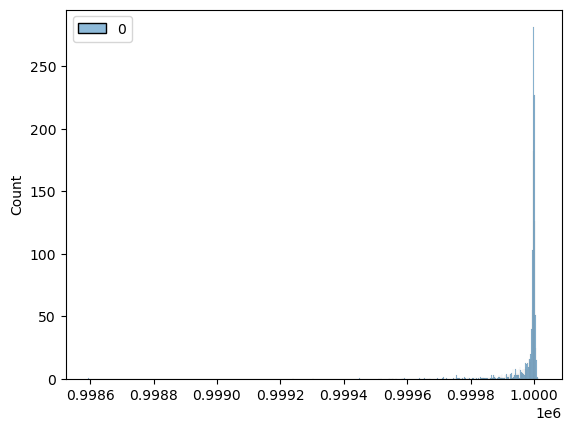

In [17]:
sns.histplot(adata_lili.raw.X.sum(axis=1))

In [26]:
mean_log_lili = per_group_cluster(adata_lili, 
                                  group_id = "paper_clusters", 
                                  target_sum = 1e6, 
                                  dataset_id = "lili")

Group_Female_FGC#1 has 425 cells. The mean of normalized, log tranformed counts across all genes is 1.9245940773121544.
Group_NA has 326 cells. The mean of normalized, log tranformed counts across all genes is 2.2665286898597903.
Group_Female_Soma#2 has 37 cells. The mean of normalized, log tranformed counts across all genes is 1.9517218905001414.
Group_Female_Soma#4 has 165 cells. The mean of normalized, log tranformed counts across all genes is 2.048275928822365.
Group_Female_FGC#4 has 46 cells. The mean of normalized, log tranformed counts across all genes is 2.1561309982738392.
Group_Female_FGC#2 has 60 cells. The mean of normalized, log tranformed counts across all genes is 2.0389303134001704.
Group_Female_FGC#3 has 102 cells. The mean of normalized, log tranformed counts across all genes is 2.154769673158896.
Group_Female_Soma#3 has 4 cells. The mean of normalized, log tranformed counts across all genes is 1.5725566557552821.
Group_Female_Soma#1 has 8 cells. The mean of normalize

## Concatenate tables
On the intersection of columns (gene names), using `join="inner"`. That means only gene names present in all datasets will be present in the concatenated table


In [29]:
mean_log_all_datasets = pd.concat([mean_log_iPSC, mean_log_tyser, mean_log_lili], 
                                   join="outer")
mean_log_all_datasets.shape

(42, 60728)

In [30]:
mean_log_all_datasets

,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,ZNF812,ZNF818P,ZNRD1-AS1,ZNRF3-AS1,ZRANB2-AS1,ZRANB2-AS2,ZSCAN16-AS1,ZSWIM8-AS1,ZUFSP,ZZZ3
iPSC_6,3.575727,4.686028,2.746611,0.900176,0.083118,2.674929,1.779697,4.515392,0.221071,2.589276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_0,1.206211,4.624648,1.778617,0.522318,0.084958,3.242518,2.300108,3.029788,0.041878,2.622001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_2,2.233235,4.609758,2.333208,1.539976,0.132373,3.825517,4.231391,5.646258,0.263990,2.774730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_1,0.716274,4.714133,1.693465,0.251774,0.106963,3.693557,2.065451,3.198554,0.000000,2.606136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_4,1.573350,4.827562,2.445769,1.285560,0.016903,2.873098,4.307308,4.349457,0.249459,2.574151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_3,1.983068,4.423160,2.506384,1.513199,0.229222,2.786798,3.075441,5.072519,0.429957,2.718578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iPSC_5,0.352948,4.996738,2.606426,1.084740,0.029940,1.533895,4.322550,5.139066,0.021341,2.017140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tyser_DE(P),1.109767,3.621783,0.547407,0.000000,0.000000,4.233193,3.589173,3.021804,0.051611,0.075871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tyser_Advanced Mesoderm,1.150780,3.585166,0.783867,0.000000,0.000000,1.356404,3.841906,0.632294,0.000000,1.689745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tyser_Primitive Streak,0.903344,3.078310,0.785663,0.000000,0.000000,1.065229,3.639272,1.527767,0.034178,1.171601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Select desired groups

In [34]:
mean_log_all_datasets_selection = mean_log_all_datasets.loc[["iPSC_6", "iPSC_0", "iPSC_2", "tyser_PGC", "lili_Male_FGC#1", "lili_Female_FGC#1", 
                                                             "lili_Male_FGC#2", "lili_Female_FGC#3", "lili_Male_FGC#3", "lili_Female_FGC#2", "lili_Female_FGC#4"],:]

### Plot a selection of genes on Heatmap
* Add dendrogram

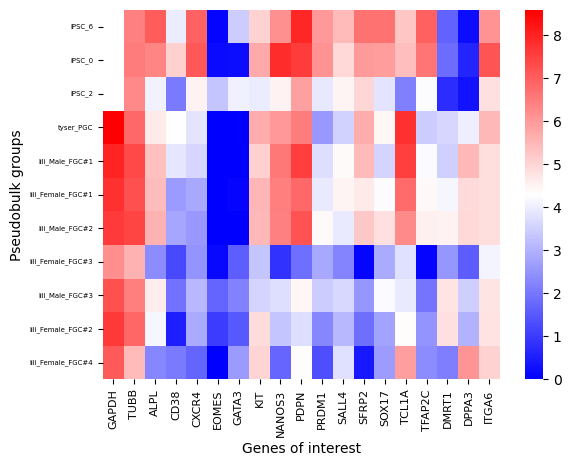

In [37]:
from matplotlib.colors import LinearSegmentedColormap

gene_list = ["GAPDH", "TUBB", "ALPL", "CD38", "CXCR4", "EOMES", "GATA3", "KIT", "NANOS3", "PDPN", "PRDM1", 
             "SALL4", "SFRP2", "SOX17", "TCL1A", "TFAP2C", "DMRT1", "DPPA3", "ITGA6"]
df_per_group_gene_selection = mean_log_all_datasets_selection.loc[:,gene_list]
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["blue", "white", "red"],
    )

heatmap = sns.heatmap(df_per_group_gene_selection,
            cmap=custom_cmap,
            yticklabels=1,
            )
plt.xlabel("Genes of interest", fontsize=10)  # X-axis label
plt.ylabel("Pseudobulk groups", fontsize=10)   # Y-axis label
plt.xticks(fontsize=8)  # X-axis tick labels
plt.yticks(fontsize=5)  # Y-axis tick labels
plt.show()
heatmap.figure.savefig("heatmap_log_sum.pdf", 
                       bbox_inches="tight",
                       dpi=300,
                       )